In [1]:
from collections import defaultdict
import itertools
import os
from pathlib import Path
import random
import time

import IPython.display

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import math

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print(X_train.shape, y_train.shape)
print(tf.reduce_min(X_train))
print(tf.reduce_max(X_train))
print(tf.reduce_min(y_train))
print(tf.reduce_max(y_train))

(50000, 32, 32, 3) (50000, 1)


2022-09-27 20:42:36.135036: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 20:42:36.573605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22309 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(9, shape=(), dtype=uint8)


In [4]:
X_train = X_train / 255.
X_test = X_test / 255.

In [5]:
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

In [6]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs", "denoising_autoencoder")

def base_weights_dir():
    return os.path.join(os.curdir, ".tfmodels", "denoising_autoencoder")

def get_tensorboard_cb(callback=keras.callbacks.TensorBoard):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return callback(run_dir)

In [40]:
# experiments
# additional depth
# nadam vs adam
# MCMC sampling
# determine how much impact gaussian noise has on representation

def build_encoder():
    return keras.models.Sequential([
        keras.layers.InputLayer(input_shape=[32, 32, 3]),
        keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
    ])

def build_classifier(lower_layers, optimizer=keras.optimizers.Adam, learning_rate=1e-3):
    model = keras.models.Sequential([
        lower_layers,
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax"),
    ])
    
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate),
        metrics=["accuracy"],
    )
    
    return model

def build_autoencoder(optimizer=keras.optimizers.Adam, learning_rate=1e-3):
    encoder = build_encoder()
    
    encoder_with_noise = keras.models.Sequential([
        keras.layers.GaussianNoise(.1, seed=42, input_shape=[32, 32, 3]),
        keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0., 1.),
        encoder
    ])
    
    decoder = keras.models.Sequential([
        keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="selu", input_shape=[1, 1, 256]),
        keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="selu"),
        keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="selu"),
        keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
        keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    ])
    
    autoencoder = keras.models.Sequential([encoder_with_noise, decoder])
    
    
    autoencoder.compile(
        loss="mse",
        optimizer=optimizer(learning_rate=learning_rate),
    )
    
    return autoencoder

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 42 (2264870929.py, line 44)

In [8]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, final_learning_rate, steps):
        self.factor = math.exp(math.log(final_learning_rate/float(initial_learning_rate))/steps)
        self.losses = []
        self.learning_rates = []
    
    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get("loss"))
        learning_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(learning_rate)
        keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate*self.factor)

def find_best_learning_rate(
    X_train,
    y_train,
    compiled_model, 
    n_steps=500,
    learning_rate_min=1e-5, 
    learning_rate_max=1e-1,
    ):
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)  
    
    learning_rate_callback = LearningRateCallback(learning_rate_min, learning_rate_max, n_steps)
    
    history = compiled_model.fit(
      X_train,
      y_train,
      epochs=1,
      steps_per_epoch=n_steps,
      callbacks=[learning_rate_callback],
    )
    
    
    learning_rates = np.array(learning_rate_callback.learning_rates)
    losses = np.array(learning_rate_callback.losses)
    idx = losses < 10000
    learning_rates_clean = learning_rates[idx]
    losses_clean = losses[idx]
    
    plt.plot(learning_rates_clean, losses_clean)
    best_idx = np.argmin(losses_clean)
    best_learning_rate = learning_rates[best_idx] / 10.
    return best_learning_rate

In [9]:
def train_model(
    X_train,
    y_train,
    X_val,
    y_val,
    compiled_model, 
    callbacks=None,
    n_epochs=500,
    batch_size=32,
    steps_per_epoch=None,
    tensorboard_callback=keras.callbacks.TensorBoard,
    ):
    callbacks = callbacks or []
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
    builtin_callbacks = [
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        get_tensorboard_cb(callback=tensorboard_callback),
    ]
    
    history = compiled_model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=(X_val, y_val),
        callbacks=callbacks + builtin_callbacks,
    )

2022-09-27 20:42:41.482561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-09-27 20:42:42.103494: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-27 20:42:42.104471: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-27 20:42:42.104485: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-27 20:42:42.105411: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-27 20:42:42.105454: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


500/500 [==============================] - 8s 12ms/step - loss: 0.0564


0.0006918303202837706

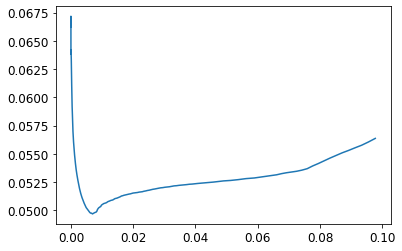

In [10]:
autoencoder = build_autoencoder(learning_rate=1e-6)
best_learning_rate = find_best_learning_rate(X_train, X_train, autoencoder, learning_rate_min=1e-6, learning_rate_max=1e-1)
best_learning_rate

In [11]:
print(32*32*3, 4*4*64)

3072 1024


In [12]:
autoencoder = build_autoencoder(learning_rate=best_learning_rate)
train_model(X_train, X_train, X_val, X_val, autoencoder)

Epoch 1/500
1250/1250 [==============================] - 15s 12ms/step - loss: 0.0179 - val_loss: 0.0135
Epoch 2/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 3/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 4/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 5/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 6/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 7/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 8/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 9/500
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 10/500
1250/1250 [==============================]

In [13]:
n = 100
idx = np.random.choice(X_train.shape[0], n, replace=False)
X_sample = X_train[idx]

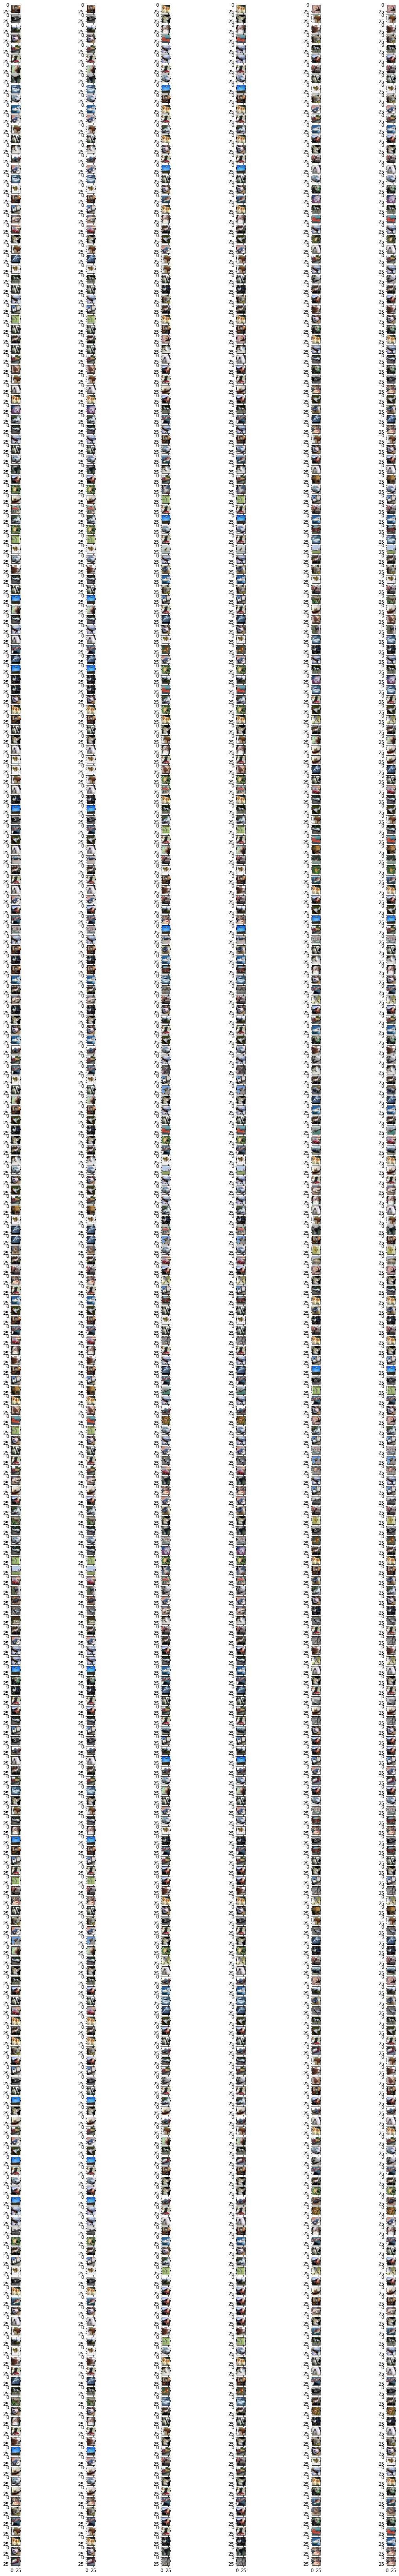

In [14]:
k = 3

codings = autoencoder.layers[0](X_sample)
reconstructions = autoencoder.layers[1](codings).numpy()

fmap_activations = tf.reduce_sum(codings, axis=[1, 2])

top_activations, top_indices = tf.math.top_k(tf.transpose(fmap_activations), k=3)


fig, axs = plt.subplots(top_activations.shape[0], 2*k, figsize=(20, 120))
for i, row in enumerate(top_indices.numpy()):
    imgs = X_sample[row]
    recs = reconstructions[row]
    for j in range(k):
        axs[i, j*2].imshow(imgs[j])
        axs[i, j*2+1].imshow(recs[j])

In [15]:
pretrained_clf_lower_layers = build_encoder()
pretrained_clf_lower_layers.set_weights(autoencoder.layers[0].layers[1].get_weights())
pretrained_clf = build_classifier(pretrained_clf_lower_layers, learning_rate=1e-3)

In [16]:
train_model(X_train, y_train, X_val, y_val, pretrained_clf, batch_size=32, steps_per_epoch=16, n_epochs=1)

11/16 [===================>..........] - ETA: 0s - loss: 2.9326 - accuracy: 0.1250

2022-09-27 21:04:11.224787: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 [==============================] - 2s 126ms/step - loss: 2.7811 - accuracy: 0.1484 - val_loss: 2.3760 - val_accuracy: 0.2181


In [17]:
clf = build_classifier(build_encoder())
# train_model(X_train, y_train, X_val, y_val, clf)
train_model(X_train, y_train, X_val, y_val, pretrained_clf, batch_size=32, steps_per_epoch=16, n_epochs=1)

16/16 [==============================] - 2s 118ms/step - loss: 1.8230 - accuracy: 0.3652 - val_loss: 2.1763 - val_accuracy: 0.2767


In [18]:
print(pretrained_clf.evaluate(X_val, y_val))
print(clf.evaluate(X_val, y_val))

313/313 [==============================] - 2s 5ms/step - loss: 2.1763 - accuracy: 0.2767
[2.176250696182251, 0.2766999900341034]
313/313 [==============================] - 2s 5ms/step - loss: 2.3381 - accuracy: 0.0948
[2.3380661010742188, 0.09480000287294388]


In [26]:
def display_samples(samples_list):
    fig, axs = plt.subplots(len(samples_list), samples_list[0].shape[0], figsize=(20, 100))
    for i, samples in enumerate(samples_list):
        for j in range(len(samples)):
            axs[i, j].imshow(samples[j])

In [47]:
# taken from validation loss above
noise_stddev = 0.0039

def mcmc_sample(denoising_autoencoder, inputs, steps=1):
    noise = keras.models.Sequential([
        keras.layers.GaussianNoise(noise_stddev, input_shape=[32, 32, 3]),
        keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0., 1.)),
    ])
    samples = inputs
    for i in range(steps):
        mean_outputs = denoising_autoencoder(samples, training=True)
        samples = noise(mean_outputs, training=True)
    return samples

In [35]:
noise_stddev

0.06244997998398398

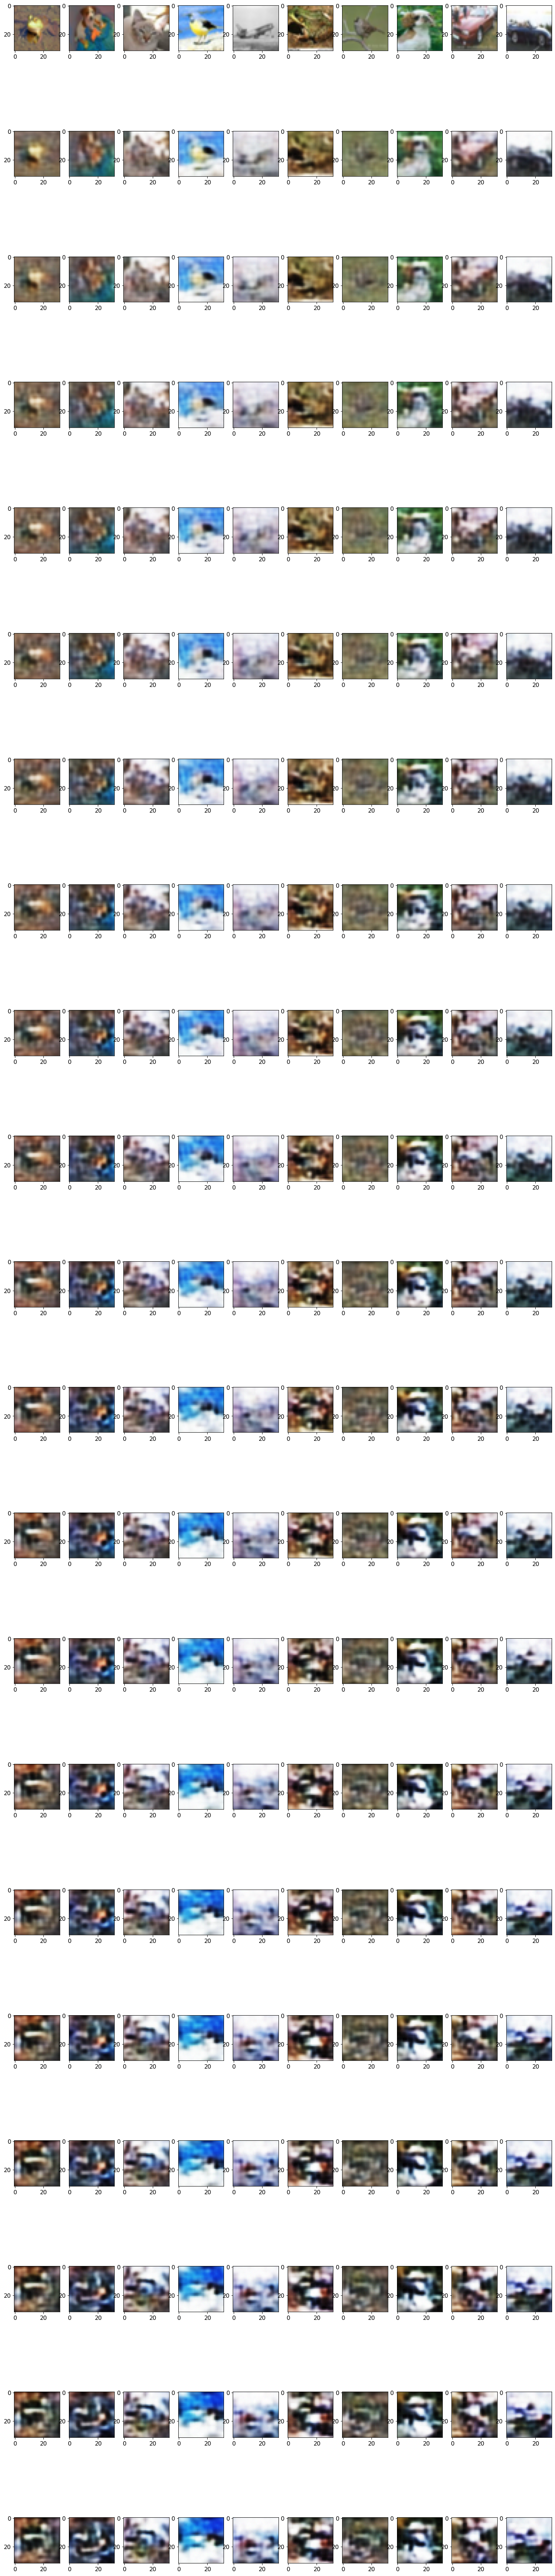

In [48]:
n = 10
idx = np.random.choice(X_train.shape[0], n, replace=False)
X_sample = X_train[idx]

samples_list = [X_sample]
for _ in range(20):
    X_sample = mcmc_sample(autoencoder, X_sample, steps=1)
    samples_list.append(X_sample)

display_samples(samples_list)